In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import os
import numpy as np
import pandas as pd
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt

sys.path.append('..')

from engine.bs_engine import get_stk_market_daily



login success!
login respond error_msg:success


In [76]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    
    params = (
            ('exitbars', 5),
            ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

#         # Indicators for the plotting show
#         bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
#         bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
#                                             subplot=True)
#         bt.indicators.StochasticSlow(self.datas[0])
#         bt.indicators.MACDHisto(self.datas[0])
#         rsi = bt.indicators.RSI(self.datas[0])
#         bt.indicators.SmoothedMovingAverage(rsi, period=10)
#         bt.indicators.ATR(self.datas[0], plot=False)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if we are in the market
        if not self.position:

#             # Not yet ... we MIGHT BUY if ...
#             if self.dataclose[0] < self.dataclose[-1]:
#                     # current close less than previous close

#                     if self.dataclose[-1] < self.dataclose[-2]:
#                         # previous close less than the previous close

#                         # BUY, BUY, BUY!!! (with default parameters)
#                         self.log('BUY CREATE, %.2f' % self.dataclose[0])

#                         # Keep track of the created order to avoid a 2nd order
#                         self.order = self.buy()

            if self.dataclose[0] > self.sma[0]:
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

#             # Already in the market ... we might sell
#             if len(self) >= (self.bar_executed + self.params.exitbars):
#                 # SELL, SELL, SELL!!! (with all possible default parameters)
#                 self.log('SELL CREATE, %.2f' % self.dataclose[0])

#                 # Keep track of the created order to avoid a 2nd order
#                 self.order = self.sell()
            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
                

In [66]:
# Obtain BaoStock data with engine
market_info = get_stk_market_daily('300750.sz', datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))
market_info = market_info.loc[:, ['date', 'code', 'open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'turn']]
market_info['openinterest'] = 0
market_info.set_index('date', inplace=True)
market_info.index = pd.to_datetime(market_info.index, format='%Y-%m-%d')

In [67]:
market_info.tail()

,code,open,high,low,close,preclose,volume,amount,turn,openinterest
date,,,,,,,,,,
2020-12-25,300750.sz,309,315.2,306.01,312.79,311,9.53993e+06,2.96755e+09,0.7727,0
2020-12-28,300750.sz,315.2,320,311,316.78,312.79,1.19731e+07,3.78228e+09,0.9698,0
2020-12-29,300750.sz,316.79,318.8,303.38,308,316.78,1.21748e+07,3.7592e+09,0.9861,0
2020-12-30,300750.sz,320,347.94,320,340,308,2.28817e+07,7.64866e+09,1.8533,0
2020-12-31,300750.sz,344.98,353.9,341.71,351.11,340,1.52005e+07,5.28367e+09,1.2312,0


In [77]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Datas are in a subfolder of the samples. Need to find where the script is
# because it could have been called from anywhere

# Create a Data Feed
data = bt.feeds.PandasData(dataname=market_info,
                           fromdate=datetime.datetime(2020, 1, 1),
                           todate=datetime.datetime(2020, 12, 31))
                            
# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2020-01-22, Close, 133.82
2020-01-22, BUY CREATE, 133.82
2020-01-23, BUY EXECUTED, Price: 132.50, Cost: 1325.00, Comm 0.00
2020-01-23, Close, 130.57
2020-02-03, Close, 135.36
2020-02-04, Close, 148.90
2020-02-05, Close, 163.79
2020-02-06, Close, 169.89
2020-02-07, Close, 160.20
2020-02-10, Close, 165.26
2020-02-11, Close, 158.40
2020-02-12, Close, 159.65
2020-02-13, Close, 156.34
2020-02-14, Close, 149.90
2020-02-17, Close, 154.10
2020-02-18, Close, 156.62
2020-02-19, Close, 153.20
2020-02-20, Close, 160.00
2020-02-21, Close, 159.90
2020-02-24, Close, 154.41
2020-02-24, SELL CREATE, 154.41
2020-02-25, SELL EXECUTED, Price: 149.74, Cost: 1325.00, Comm 0.00
2020-02-25, OPERATION PROFIT, GROSS 172.40, NET 172.40
2020-02-25, Close, 161.85
2020-02-25, BUY CREATE, 161.85
2020-02-26, BUY EXECUTED, Price: 158.70, Cost: 1587.00, Comm 0.00
2020-02-26, Close, 152.86
2020-02-26, SELL CREATE, 152.86
2020-02-27, SELL EXECUTED, Price: 155.10, Cost: 1587.00, Comm 0.0

<IPython.core.display.Javascript object>


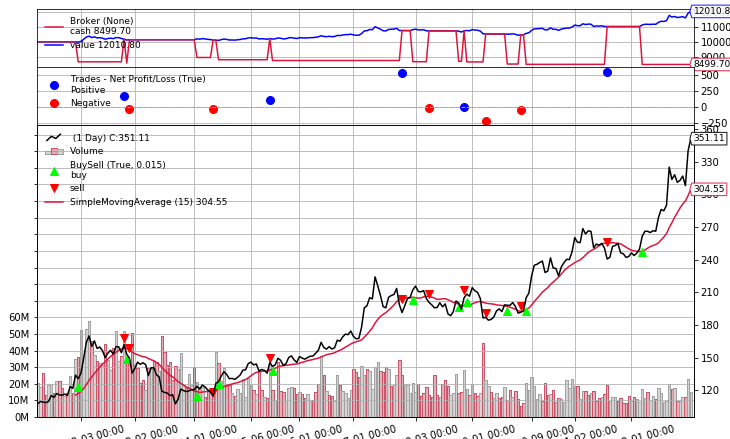

[[<Figure size 432x288 with 4 Axes>]]

In [78]:
cerebro.plot()

In [79]:
cerebro.broker.getvalue()

12010.800000000001